In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import fftpack
%pylab inline
plt.style.use('seaborn-whitegrid')
pylab.rcParams['figure.figsize'] = (22, 6)
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

Populating the interactive namespace from numpy and matplotlib


C:\Users\s158079\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'fftpack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [71]:
df = pd.read_csv('Data/BMS/Rooms and HVAC/RCU middenhal.csv', delimiter=';', encoding='utf-8')

In [72]:
df_data = df[['Tijdstip', 'Gemiddelde ruimtetemp [°C] - RCU Middelhal 255 ()', 'Luchtkwaliteitopnemer [ppm] - RCU Middelhal 255 (255QT01)']]
df_data.is_copy = False
df_data.columns = ['Time', 'Temperature', 'CO2']

In [73]:
df_data.is_copy = False
df_data['Time'] = pd.to_datetime(df_data['Time'], format="%d-%m-%Y %H:%M.%S")

df_data['Temperature'] = [str(x).replace(',', '.') for x in df_data['Temperature']]
df_data['Temperature'] = pd.to_numeric(df_data['Temperature'], errors='coerce')
df_data['CO2'] = pd.to_numeric(df_data['CO2'], errors='coerce')

In [74]:
df_temp.sort_values(['Time'], inplace=True)

In [75]:
df_data = df_data.loc[df_data['Time'] > datetime.datetime(2017, 10, 23, 9, 0, 0)]
df_data = df_data.loc[df_data['Time'] <= datetime.datetime(2018, 2, 28, 13, 56, 0)]

In [76]:
mean = df_data['Temperature'].mean()
df_data['Temperature_normalized'] = [(i-mean)/mean for i in list(df_data['Temperature'])]

mean = df_data['CO2'].mean()
df_data['CO2_normalized'] = [(i-mean)/mean for i in list(df_data['CO2'])]

In [78]:
def shift(row, mean):

    return (row - mean)

def multi_resolution(df, column1, column2, freq):

    grouped =  df.groupby(pd.Grouper(key='Time', freq=freq))
    norm_df = pd.DataFrame()
    
    mean_temp_list = []
    mean_CO2_list = []
    
    for name, group in grouped:
        df_sub = pd.DataFrame(group)
        
        mean_temp = df_sub['Temperature_normalized'].mean()
        mean_temp_list.append(mean_temp)
        df_sub['Temperature_piecewise'] = mean_temp
        
        mean_CO2 = df_sub['CO2_normalized'].mean()
        mean_CO2_list.append(mean_CO2)
        df_sub['CO2_piecewise'] = mean_CO2
        
        df_sub['Temperature_normalized_shifted'] = df_sub.apply(lambda row: shift(row[column1], mean_temp), axis=1)
        df_sub['CO2_normalized_shifted'] = df_sub.apply(lambda row: shift(row[column2], mean_CO2), axis=1)
        
        norm_df = norm_df.append(df_sub)
    
    return norm_df, mean_temp_list, mean_CO2_list

In [79]:
df_data, mean_temp_day, mean_CO2_day = multi_resolution(df_data, 'Temperature_normalized', \
                                                        'CO2_normalized', 'D')

df_data.columns = ['Time', 'Temperature', 'CO2', 'Temperature_normalized', 'CO2_normalized', \
                  'Temperature_piecewise_day', 'CO2_piecewise_day', 'Temperature_shifted_day', 'CO2_shifted_day']

df_data, mean_temp_2H, mean_CO2_2H = multi_resolution(df_data, 'Temperature_shifted_day', \
                                                        'CO2_shifted_day', '2H')

df_data.columns = ['Time', 'Temperature', 'CO2', 'Temperature_normalized', 'CO2_normalized', \
                  'Temperature_piecewise_day', 'CO2_piecewise_day', 'Temperature_shifted_day', 'CO2_shifted_day', \
                  'Temperature_piecewise_2H', 'CO2_piecewise_2H', 'Temperature_shifted_2H', 'CO2_shifted_2H']

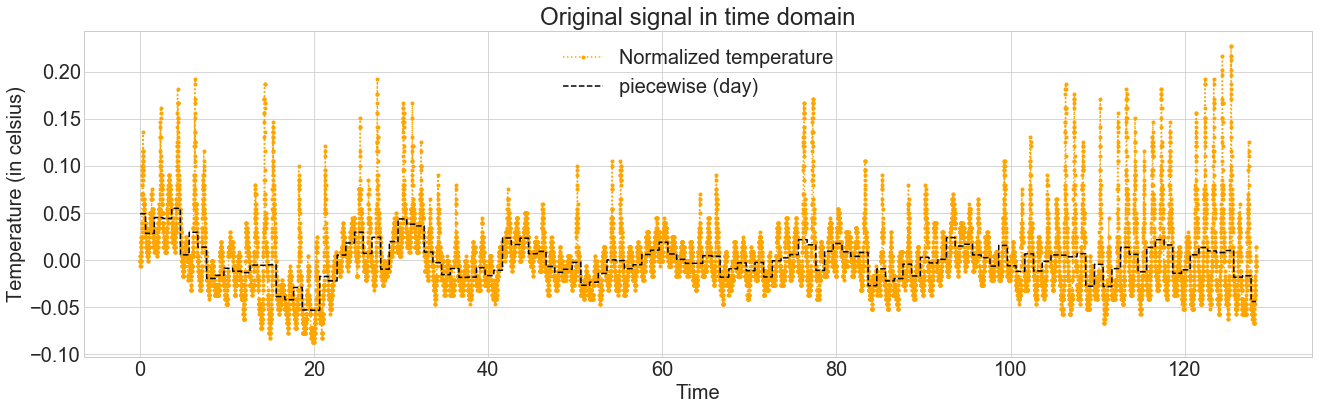

In [93]:
x_range =[(m*480)/(60*60*24) for m in range(1, len(df_data['Temperature_normalized'])+1)]
plt.plot(x_range, df_data['Temperature_normalized'], linestyle=':', marker='.', color="orange", label="Normalized temperature")
plt.plot(x_range, df_data['Temperature_piecewise_day'], linestyle='--', color="black", label = "piecewise (day)")
plt.legend()
plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Temperature (in celsius)')
plt.show()

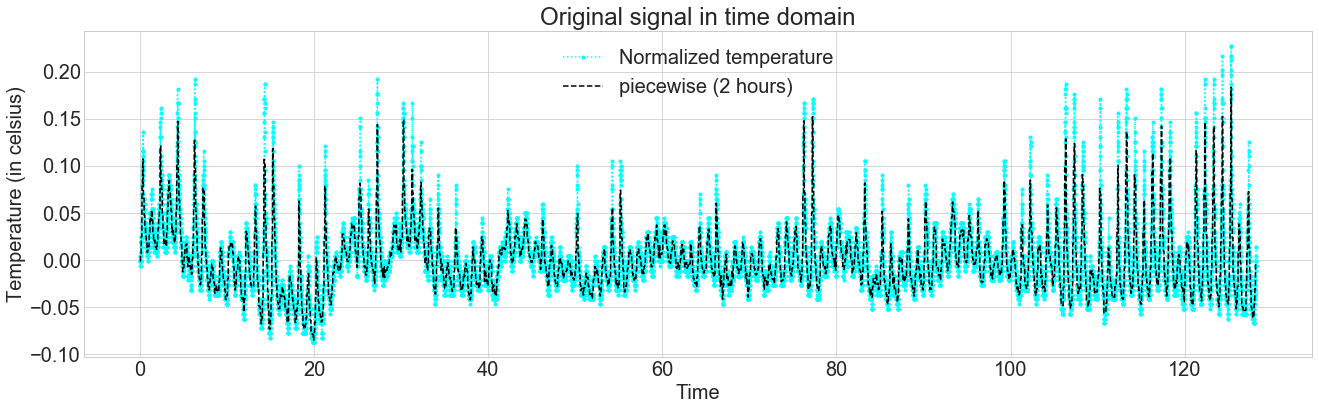

In [96]:
x_range =[(m*480)/(60*60*24) for m in range(1, len(df_data['Temperature_normalized'])+1)]
plt.plot(x_range, df_data['Temperature_normalized'], linestyle=':', marker='.', color="cyan", label="Normalized temperature")
plt.plot(x_range, df_data['Temperature_piecewise_2H'], linestyle='--', color="black", label = "piecewise (2 hours)")
plt.legend()
plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Temperature (in celsius)')
plt.show()

In [103]:
def autocorr(x):
    result = numpy.correlate(x, x, mode='full')
    return result[int(result.size/2):]

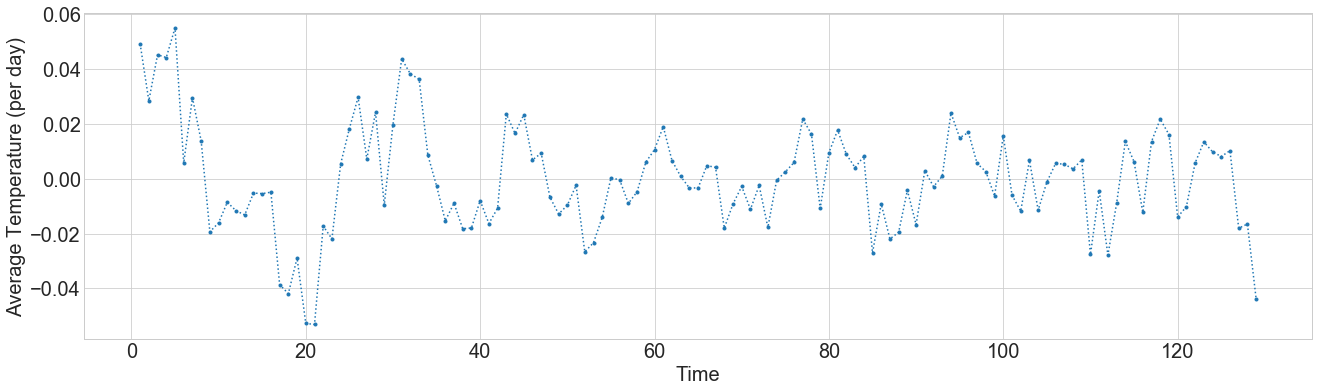

In [104]:
plt.plot(range(1, len(mean_temp_day)+1), mean_temp_day, linestyle=':', marker='.')
# plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Average Temperature (per day)')
plt.show()

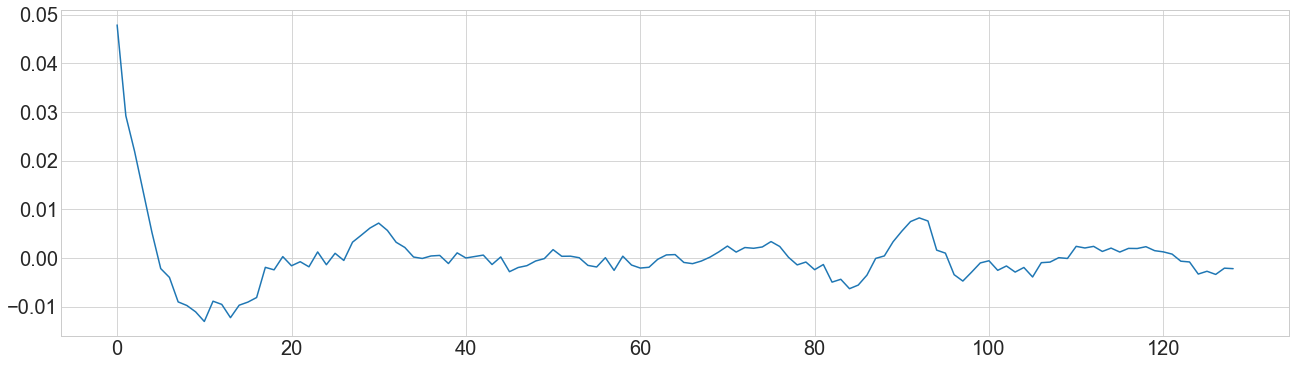

In [105]:
plt.plot(autocorr(mean_temp_day))

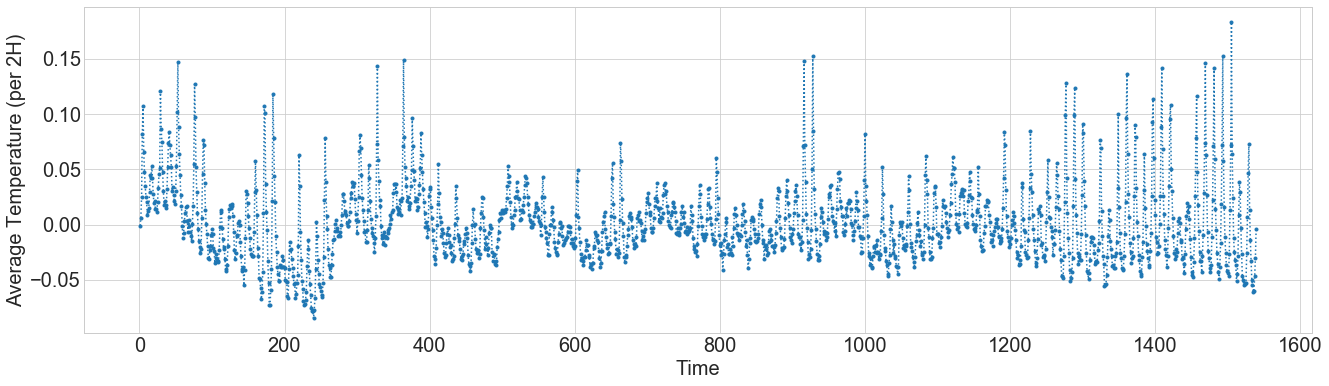

In [100]:
plt.plot(range(1, len(mean_temp_2H)+1), mean_temp_2H, linestyle=':', marker='.')
# plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Average Temperature (per 2H)')
plt.show()

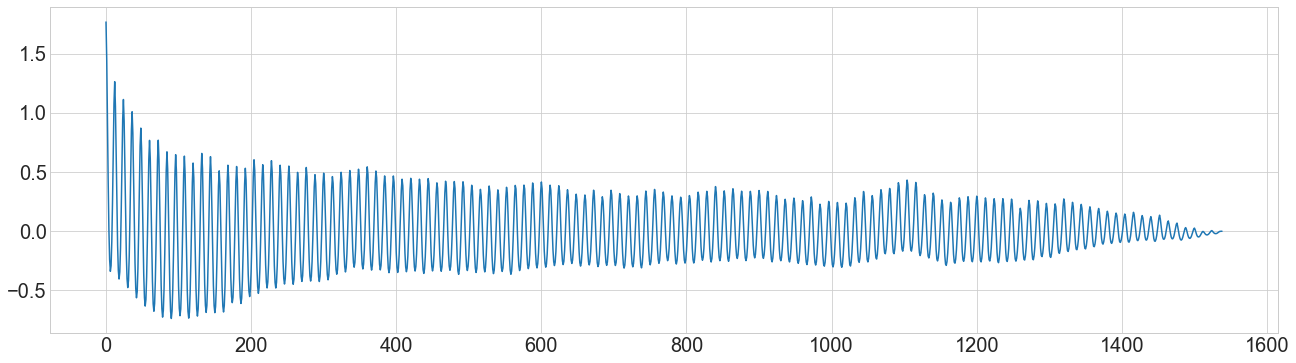

In [106]:
plt.plot(autocorr(mean_temp_2H))

In [ ]:
 
plt.plot(x_range, norm_df['Temperature_normalized'], linestyle=':', marker='.')
plt.title('Signal normalized per day')
plt.ylabel('Normalized Temperature')
plt.xlabel('Time (days)')
plt.show()

In [ ]:
mean1 = np.mean(mean_temp_list)
new_mean_list = [(i-mean1)/mean1 for i in mean_temp_list]

In [ ]:
pylab.rcParams['figure.figsize'] = (22, 6)
plt.plot(range(1, len(mean_temp_list)+1), new_mean_list, linestyle=':', marker='.')
plt.title('Mean temperature/ day')
plt.ylabel('Temperature (in celsius)')
plt.xlabel('Time (days)')
plt.show()

In [ ]:
X_temp_norm = np.fft.fft(norm_df['Temperature_normalized'], norm="ortho")
X_temp_scaled = np.fft.fft(norm_df['Temperature_scaled'], norm="ortho")
X_temp_mean = np.fft.fft(new_mean_list, norm="ortho")

In [ ]:
freqs_norm = np.fft.fftfreq(len(norm_df['Temperature_normalized'])) * (1/480)
freqs_scaled = np.fft.fftfreq(len(norm_df['Temperature_scaled'])) * (1/480)
freqs_mean = np.fft.fftfreq(len(mean_temp_list))

In [ ]:
pylab.rcParams['figure.figsize'] = (10, 7)
plt.plot(freqs_norm, abs(X_temp_norm))
plt.xlabel('Frequency')
plt.title('DFT')

In [ ]:
pylab.rcParams['figure.figsize'] = (10, 7)
plt.plot(freqs_mean, abs(X_temp_mean))
plt.xlabel('Frequency')
plt.title('DFT')

In [ ]:
abs(X_temp_mean)

In [ ]:
num = len(X_temp_norm)/2
num

In [ ]:
def dft_map(X, Fs, shift=True):
    resolution = float(Fs) / len(X)
    if shift:
        n, Y = dft_shift(X)
    else:
        Y = X
        n = np.arange(0, len(Y))
    f = n * resolution
    return f, Y

In [ ]:
Fs = 1/480
y = X_temp_norm
resolution = Fs/(len(y))
n = np.arange(0, len(y))
f = n * resolution
pylab.rcParams['figure.figsize'] = (10, 7)
f_new = [i*8*10800 for i in f]
half = len(f_new)/2
plt.plot(f_new[:int(half)], abs(y[:int(half)]))
plt.xlabel('Frequency')
plt.title('DFT')

In [ ]:
Fs3 = 1
y3 = X_temp_mean
resolution3 = Fs3/len(y3)
n3 = np.arange(0, len(y3))
f3 = n3 * resolution3
pylab.rcParams['figure.figsize'] = (10, 7)
f_new3 = f3
half3 = len(f_new3)/2
plt.plot(f_new3[:int(half3)], abs(y3[:int(half3)]))
plt.xlabel('Frequency')
plt.title('DFT')

In [ ]:
filtered_y3 = [i if abs(i)>0.025 else 0 for i in y3]
reconstructed3 = np.fft.ifft(filtered_y3, norm="ortho")

In [ ]:
pylab.rcParams['figure.figsize'] = (22, 6)
plt.plot(range(1, len(mean_temp_list)+1), new_mean_list, linestyle=':', marker='.')
plt.title('Mean temperature/ day')
plt.ylabel('Temperature (in celsius)')
plt.xlabel('Time (days)')
plot(range(1, len(mean_temp_list)+1), reconstructed3)
plt.show()

In [ ]:

print(f_new[-1])

In [ ]:
for i in range(len(y[:12587])):
    if abs(y[i])>0.5:
        print(f_new[i])
        print(abs(y[i]))

In [ ]:
60*24*7.5

In [ ]:
[k for k in range(len(y))if abs(y[k]) > 1.5]

In [ ]:
X_temp_norm_5 = [k  if abs(k) > 5 else 0 for k in X_temp_norm]
X_temp_norm_10 = [k  if abs(k) > 10 else 0 for k in X_temp_norm]
X_temp_norm_50 = [k  if abs(k) > 50 else 0 for k in X_temp_norm]
X_temp_norm_100 = [k  if abs(k) > 100 else 0 for k in X_temp_norm]
X_temp_norm_250 = [k  if abs(k) > 250 else 0 for k in X_temp_norm]

In [ ]:
x_orig = np.fft.ifft(X_temp_norm)
x_reconstruct_5 = np.fft.ifft(X_temp_norm_5)
x_reconstruct_10 = np.fft.ifft(X_temp_norm_10)
x_reconstruct_50 = np.fft.ifft(X_temp_norm_50)
x_reconstruct_100 = np.fft.ifft(X_temp_norm_100)
x_reconstruct_250 = np.fft.ifft(X_temp_norm_250)

In [ ]:
norm_df.sort_values(['Time'], inplace=True)
norm_df.reset_index(drop=True, inplace=True)

In [ ]:
normalized_y =norm_df['Temperature_normalized'].rolling(window=180).mean()
normalized_y.fillna(0, inplace=True)

In [ ]:
# pylab.rcParams['figure.figsize'] = (22, 8)
# plt.plot(normalized_y)

In [ ]:
# new_t = [(m*480)/(60*60*24) for m in range(len(x_orig))]

In [ ]:
# plt.plot(new_t, x_orig)